# Subbundles Part 7: Test-Retest, Intrasubject, Lateralization

In [1]:
from utils import *

# filesystem
import os.path as op
import tempfile

# data structures
import numpy as np
import pandas as pd

# neuroimaging
import nibabel as nib

from dipy.io.streamline import load_tractogram
from dipy.io.stateful_tractogram import StatefulTractogram
from dipy.stats.analysis import afq_profile, gaussian_weights

# models
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.spatial.distance import dice

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from dipy.viz import window, actor
from IPython.display import Image

# AFQ
from AFQ import api
import AFQ.data as afd
from AFQ.utils.volume import density_map, dice_coeff

from AFQ.viz.fury_backend import visualize_volume, visualize_bundles

/Users/bloomdt/anaconda/envs/subbundles/lib/python3.8/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Test Retest Metadata

In [2]:
test_retest_dir = 'HCP_test_retest'
test_retest_sessions = ['test', 'retest']
test_retest_dataset_names = ['HCP', 'HCP_retest']

Test Retest AFQ

In [3]:
display('HCP')
myafq_test = get_afq('HCP')
display(myafq_test.data_frame)

display('HCP_retest')
myafq_retest = get_afq('HCP_retest')
display(myafq_retest.data_frame)

'HCP'

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 


,subject,dwi_file,bvec_file,bval_file,custom_tract,reg_subject,ses,timing,sl_counts,results_dir,gtab,dwi_affine,dwi_img
0,100307,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
1,103818,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
2,105923,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
3,111312,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
4,114823,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
5,115320,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...


'HCP_retest'

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 


,subject,dwi_file,bvec_file,bval_file,custom_tract,reg_subject,ses,timing,sl_counts,results_dir,gtab,dwi_affine,dwi_img
0,103818,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
1,105923,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
2,111312,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
3,114823,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
4,115320,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...


Select Subjects

In [4]:
subjects = get_subjects_small('HCP_retest')
# subjects = ['103818']
# subjects = ['105923']
display(subjects)

['103818', '105923']

Select Bundles

In [5]:
# bundle_names = [*myafq_retest.bundle_dict]
# bundle_names = ['ARC_L', 'ARC_R', 'CST_L', 'CST_R', 'FP'] 
# bundle_names = ['SLF_L', 'SLF_R', 'ARC_L', 'ARC_R', 'CST_L', 'CST_R', 'FP']
bundle_names = ['SLF_L', 'SLF_R']
# bundle_names = ['SLF_L']
display(bundle_names)

['SLF_L', 'SLF_R']

Output directories

In [6]:
for bundle_name in bundle_names:
    make_dirs(myafq_retest, test_retest_dir, bundle_name, subjects)
    
target_dirs = {}

for subject in subjects:
    target_dirs[subject] = {}
    
    loc_retest = get_iloc(myafq_retest, subject)

    for bundle_name in bundle_names:
        target_dir = get_dir_name(myafq_retest, test_retest_dir, bundle_name, loc_retest)
        target_dirs[subject][bundle_name] = target_dir
        
target_dirs_df = pd.DataFrame.from_dict(
    {(i,j): target_dirs[i][j] for i in target_dirs.keys() for j in target_dirs[i].keys()}, 
    orient='index', 
    columns=['target directory']
)

with pd.option_context('display.max_colwidth', -1):
    display(target_dirs_df)

,target directory
"(103818, SLF_L)",subbundles/HCP_test_retest/SLF_L/103818/01
"(103818, SLF_R)",subbundles/HCP_test_retest/SLF_R/103818/01
"(105923, SLF_L)",subbundles/HCP_test_retest/SLF_L/105923/01
"(105923, SLF_R)",subbundles/HCP_test_retest/SLF_R/105923/01


Data directories

In [7]:
source_dirs = {}

for subject in subjects:
    source_dirs[subject] = {}
    
    loc_test  = get_iloc(myafq_test, subject)
    loc_retest = get_iloc(myafq_retest, subject)

    for bundle_name in bundle_names:
        source_dirs[subject][bundle_name] = {}
        
        for dataset_name, ses, myafq, loc in zip(test_retest_dataset_names, test_retest_sessions, [myafq_test, myafq_retest], [loc_test, loc_retest]):
            source_dir = get_dir_name(myafq, dataset_name, bundle_name, loc)
            source_dirs[subject][bundle_name][ses] = source_dir
        
source_dirs_df = pd.DataFrame.from_dict(
    {(i,j,k): source_dirs[i][j][k] for i in source_dirs.keys() for j in source_dirs[i].keys() for k in source_dirs[i][j].keys()}, 
    orient='index', 
    columns=['source directory']
)

with pd.option_context('display.max_colwidth', -1):
    display(source_dirs_df)

,source directory
"(103818, SLF_L, test)",subbundles/HCP/SLF_L/103818/01
"(103818, SLF_L, retest)",subbundles/HCP_retest/SLF_L/103818/01
"(103818, SLF_R, test)",subbundles/HCP/SLF_R/103818/01
"(103818, SLF_R, retest)",subbundles/HCP_retest/SLF_R/103818/01
"(105923, SLF_L, test)",subbundles/HCP/SLF_L/105923/01
"(105923, SLF_L, retest)",subbundles/HCP_retest/SLF_L/105923/01
"(105923, SLF_R, test)",subbundles/HCP/SLF_R/105923/01
"(105923, SLF_R, retest)",subbundles/HCP_retest/SLF_R/105923/01


Tractogram files

In [9]:
tg_fnames = {}
tractograms = {}

for subject in subjects:
    tg_fnames[subject] = {}
    tractograms[subject] = {}
    
    loc_test  = get_iloc(myafq_test, subject)
    loc_retest = get_iloc(myafq_retest, subject)

    for bundle_name in bundle_names:
        tg_fnames[subject][bundle_name] = {}
        tractograms[subject][bundle_name] = {}

        for dataset_name, ses, myafq, loc in zip(test_retest_dataset_names, test_retest_sessions, [myafq_test, myafq_retest], [loc_test, loc_retest]):
            tg_fnames[subject][bundle_name][ses] = get_tractogram_filename(myafq, bundle_name, loc)
            tractograms[subject][bundle_name][ses] = load_tractogram(tg_fnames[subject][bundle_name][ses], 'same')
            
tg_df = pd.DataFrame.from_dict(
    {(i,j,k): [len(tractograms[i][j][k].streamlines), tractograms[i][j][k].affine, tg_fnames[i][j][k]] for i in tg_fnames.keys() for j in tg_fnames[i].keys() for k in tg_fnames[i][j].keys()}, 
    orient='index', 
    columns=['number of streamlines', 'affine', 'tratogram files']
)

with pd.option_context('display.max_colwidth', -1):
    display(tg_df)

,number of streamlines,affine,tratogram files
"(103818, SLF_L, test)",724,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -126.0], [0.0, 0.0, 1.25, -72.0], [0.0, 0.0, 0.0, 1.0]]",/Users/bloomdt/AFQ_data/HCP_1200/derivatives/afq/sub-103818/ses-01/clean_bundles/sub-103818_dwi_space-RASMM_model-DTI_desc-det-AFQ-SLF_L_tractography.trk
"(103818, SLF_L, retest)",814,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -126.0], [0.0, 0.0, 1.25, -72.0], [0.0, 0.0, 0.0, 1.0]]",/Users/bloomdt/AFQ_data/hcp_retest/derivatives/afq/sub-103818/ses-01/clean_bundles/sub-103818_dwi_space-RASMM_model-DTI_desc-det-AFQ-SLF_L_tractography.trk
"(103818, SLF_R, test)",1160,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -126.0], [0.0, 0.0, 1.25, -72.0], [0.0, 0.0, 0.0, 1.0]]",/Users/bloomdt/AFQ_data/HCP_1200/derivatives/afq/sub-103818/ses-01/clean_bundles/sub-103818_dwi_space-RASMM_model-DTI_desc-det-AFQ-SLF_R_tractography.trk
"(103818, SLF_R, retest)",1299,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -126.0], [0.0, 0.0, 1.25, -72.0], [0.0, 0.0, 0.0, 1.0]]",/Users/bloomdt/AFQ_data/hcp_retest/derivatives/afq/sub-103818/ses-01/clean_bundles/sub-103818_dwi_space-RASMM_model-DTI_desc-det-AFQ-SLF_R_tractography.trk
"(105923, SLF_L, test)",550,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -126.0], [0.0, 0.0, 1.25, -72.0], [0.0, 0.0, 0.0, 1.0]]",/Users/bloomdt/AFQ_data/HCP_1200/derivatives/afq/sub-105923/ses-01/clean_bundles/sub-105923_dwi_space-RASMM_model-DTI_desc-det-AFQ-SLF_L_tractography.trk
"(105923, SLF_L, retest)",694,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -126.0], [0.0, 0.0, 1.25, -72.0], [0.0, 0.0, 0.0, 1.0]]",/Users/bloomdt/AFQ_data/hcp_retest/derivatives/afq/sub-105923/ses-01/clean_bundles/sub-105923_dwi_space-RASMM_model-DTI_desc-det-AFQ-SLF_L_tractography.trk
"(105923, SLF_R, test)",769,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -126.0], [0.0, 0.0, 1.25, -72.0], [0.0, 0.0, 0.0, 1.0]]",/Users/bloomdt/AFQ_data/HCP_1200/derivatives/afq/sub-105923/ses-01/clean_bundles/sub-105923_dwi_space-RASMM_model-DTI_desc-det-AFQ-SLF_R_tractography.trk
"(105923, SLF_R, retest)",876,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -126.0], [0.0, 0.0, 1.25, -72.0], [0.0, 0.0, 0.0, 1.0]]",/Users/bloomdt/AFQ_data/hcp_retest/derivatives/afq/sub-105923/ses-01/clean_bundles/sub-105923_dwi_space-RASMM_model-DTI_desc-det-AFQ-SLF_R_tractography.trk


Select Models

In [292]:
# model_types = ['sc', 'gmm', 'ms', 'hier']
model_types = ['sc', 'mase']
# model_types = ['sc']
# model_types = ['mase']

display(model_types)

['sc', 'mase']

#### Adjacencies

Default

In [297]:
adjacencies = {}
model_names = {}
idxs = {}

for subject in subjects:
    adjacencies[subject] = {}
    model_names[subject] = {}
    idxs[subject] = {}
    
    loc_test  = get_iloc(myafq_test, subject)
    loc_retest = get_iloc(myafq_retest, subject)
    
    for bundle_name in bundle_names:
        adjacencies[subject][bundle_name] = {}
        model_names[subject][bundle_name] = {}
        idxs[subject][bundle_name] = {}

        
        target_dir = target_dirs[subject][bundle_name]
        
        for dataset_name, ses, myafq, loc in zip(test_retest_dataset_names, test_retest_sessions, [myafq_test, myafq_retest], [loc_test, loc_retest]):
            model_names[subject][bundle_name][ses] = []
            idxs[subject][bundle_name][ses] = []

            
            source_dir = source_dirs[subject][bundle_name][ses]

            # various filterings to select desired adjacencies
#             adjacencies_names = ['fa', 'r2', 'md', 'wt', 'mdf']
#             adjacencies_names = get_adjacencies_names(source_dir)
#             adjacencies_names=[adjacencies_names[adjacencies_names.index('fa_r2')]]

#             adjacencies_names = get_adjacencies_names(source_dir, '*wt_[01]_*pairwise*')
            adjacencies_names = get_adjacencies_names(source_dir, '*wt*pairwise*')

            adjacencies[subject][bundle_name][ses] = adjacencies_names

            for adjacency_name in adjacencies_names:
                for model_type in model_types:
                    # mase is special case
                    if model_type == 'mase':
                        continue
                        
                    label = f'{model_type}_{adjacency_name}'
                    model_names[subject][bundle_name][ses].append(label)

                    idx = np.load(op.join(source_dir, f'{label}_idx.npy'))
                    idxs[subject][bundle_name][ses].append(idx)

                    
adjacencies_df = pd.DataFrame.from_dict(
    {(i,j,k): [adjacencies[i][j][k]] for i in adjacencies.keys() for j in adjacencies[i].keys() for k in adjacencies[i][j].keys()}, 
    orient='index', 
    columns=['adjacencies']
)

with pd.option_context('display.max_colwidth', -1):
    display(adjacencies_df)
    
model_names_df = pd.DataFrame.from_dict(
    {(i,j,k): [model_names[i][j][k]] for i in model_names.keys() for j in model_names[i].keys() for k in model_names[i][j].keys()}, 
    orient='index', 
    columns=['models']
)

with pd.option_context('display.max_colwidth', -1):
    display(model_names_df)

,adjacencies
"(103818, SLF_L, test)","[wt_0_pairwise_warped_fa_r2_10_is_mdf, wt_1_pairwise_warped_fa_r2_9_is_mdf, wt_2_pairwise_warped_fa_r2_8_is_mdf, wt_3_pairwise_warped_fa_r2_7_is_mdf, wt_4_pairwise_warped_fa_r2_6_is_mdf, wt_5_pairwise_warped_fa_r2_5_is_mdf, wt_6_pairwise_warped_fa_r2_4_is_mdf, wt_7_pairwise_warped_fa_r2_3_is_mdf, wt_8_pairwise_warped_fa_r2_2_is_mdf, wt_9_pairwise_warped_fa_r2_1_is_mdf, wt_10_pairwise_warped_fa_r2_0_is_mdf]"
"(103818, SLF_L, retest)","[wt_0_pairwise_warped_fa_r2_10_is_mdf, wt_1_pairwise_warped_fa_r2_9_is_mdf, wt_2_pairwise_warped_fa_r2_8_is_mdf, wt_3_pairwise_warped_fa_r2_7_is_mdf, wt_4_pairwise_warped_fa_r2_6_is_mdf, wt_5_pairwise_warped_fa_r2_5_is_mdf, wt_6_pairwise_warped_fa_r2_4_is_mdf, wt_7_pairwise_warped_fa_r2_3_is_mdf, wt_8_pairwise_warped_fa_r2_2_is_mdf, wt_9_pairwise_warped_fa_r2_1_is_mdf, wt_10_pairwise_warped_fa_r2_0_is_mdf]"
"(103818, SLF_R, test)","[wt_0_pairwise_warped_fa_r2_10_is_mdf, wt_1_pairwise_warped_fa_r2_9_is_mdf, wt_2_pairwise_warped_fa_r2_8_is_mdf, wt_3_pairwise_warped_fa_r2_7_is_mdf, wt_4_pairwise_warped_fa_r2_6_is_mdf, wt_5_pairwise_warped_fa_r2_5_is_mdf, wt_6_pairwise_warped_fa_r2_4_is_mdf, wt_7_pairwise_warped_fa_r2_3_is_mdf, wt_8_pairwise_warped_fa_r2_2_is_mdf, wt_9_pairwise_warped_fa_r2_1_is_mdf, wt_10_pairwise_warped_fa_r2_0_is_mdf]"
"(103818, SLF_R, retest)","[wt_0_pairwise_warped_fa_r2_10_is_mdf, wt_1_pairwise_warped_fa_r2_9_is_mdf, wt_2_pairwise_warped_fa_r2_8_is_mdf, wt_3_pairwise_warped_fa_r2_7_is_mdf, wt_4_pairwise_warped_fa_r2_6_is_mdf, wt_5_pairwise_warped_fa_r2_5_is_mdf, wt_6_pairwise_warped_fa_r2_4_is_mdf, wt_7_pairwise_warped_fa_r2_3_is_mdf, wt_8_pairwise_warped_fa_r2_2_is_mdf, wt_9_pairwise_warped_fa_r2_1_is_mdf, wt_10_pairwise_warped_fa_r2_0_is_mdf]"
"(105923, SLF_L, test)","[wt_0_pairwise_warped_fa_r2_10_is_mdf, wt_1_pairwise_warped_fa_r2_9_is_mdf, wt_2_pairwise_warped_fa_r2_8_is_mdf, wt_3_pairwise_warped_fa_r2_7_is_mdf, wt_4_pairwise_warped_fa_r2_6_is_mdf, wt_5_pairwise_warped_fa_r2_5_is_mdf, wt_6_pairwise_warped_fa_r2_4_is_mdf, wt_7_pairwise_warped_fa_r2_3_is_mdf, wt_8_pairwise_warped_fa_r2_2_is_mdf, wt_9_pairwise_warped_fa_r2_1_is_mdf, wt_10_pairwise_warped_fa_r2_0_is_mdf]"
"(105923, SLF_L, retest)","[wt_0_pairwise_warped_fa_r2_10_is_mdf, wt_1_pairwise_warped_fa_r2_9_is_mdf, wt_2_pairwise_warped_fa_r2_8_is_mdf, wt_3_pairwise_warped_fa_r2_7_is_mdf, wt_4_pairwise_warped_fa_r2_6_is_mdf, wt_5_pairwise_warped_fa_r2_5_is_mdf, wt_6_pairwise_warped_fa_r2_4_is_mdf, wt_7_pairwise_warped_fa_r2_3_is_mdf, wt_8_pairwise_warped_fa_r2_2_is_mdf, wt_9_pairwise_warped_fa_r2_1_is_mdf, wt_10_pairwise_warped_fa_r2_0_is_mdf]"
"(105923, SLF_R, test)","[wt_0_pairwise_warped_fa_r2_10_is_mdf, wt_1_pairwise_warped_fa_r2_9_is_mdf, wt_2_pairwise_warped_fa_r2_8_is_mdf, wt_3_pairwise_warped_fa_r2_7_is_mdf, wt_4_pairwise_warped_fa_r2_6_is_mdf, wt_5_pairwise_warped_fa_r2_5_is_mdf, wt_6_pairwise_warped_fa_r2_4_is_mdf, wt_7_pairwise_warped_fa_r2_3_is_mdf, wt_8_pairwise_warped_fa_r2_2_is_mdf, wt_9_pairwise_warped_fa_r2_1_is_mdf, wt_10_pairwise_warped_fa_r2_0_is_mdf]"
"(105923, SLF_R, retest)","[wt_0_pairwise_warped_fa_r2_10_is_mdf, wt_1_pairwise_warped_fa_r2_9_is_mdf, wt_2_pairwise_warped_fa_r2_8_is_mdf, wt_3_pairwise_warped_fa_r2_7_is_mdf, wt_4_pairwise_warped_fa_r2_6_is_mdf, wt_5_pairwise_warped_fa_r2_5_is_mdf, wt_6_pairwise_warped_fa_r2_4_is_mdf, wt_7_pairwise_warped_fa_r2_3_is_mdf, wt_8_pairwise_warped_fa_r2_2_is_mdf, wt_9_pairwise_warped_fa_r2_1_is_mdf, wt_10_pairwise_warped_fa_r2_0_is_mdf]"


,models
"(103818, SLF_L, test)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf]"
"(103818, SLF_L, retest)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf]"
"(103818, SLF_R, test)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf]"
"(103818, SLF_R, retest)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf]"
"(105923, SLF_L, test)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf]"
"(105923, SLF_L, retest)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf]"
"(105923, SLF_R, test)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf]"
"(105923, SLF_R, retest)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf]"


MASE

In [298]:
if 'mase' in model_types:
    # other model types would have already initialized model_names and idxs in previous cell
    initialize_data_structs = len(model_types) == 1

    if initialize_data_structs:
        model_names = {}
        idxs = {}

    for subject in subjects:
        if initialize_data_structs:
            model_names[subject] = {}
            idxs[subject] = {}

        loc_test  = get_iloc(myafq_test, subject)
        loc_retest = get_iloc(myafq_retest, subject)

        for bundle_name in bundle_names:
            if initialize_data_structs:
                model_names[subject][bundle_name] = {}
                idxs[subject][bundle_name] = {}

            for dataset_name, ses, myafq, loc in zip(test_retest_dataset_names, test_retest_sessions, [myafq_test, myafq_retest], [loc_test, loc_retest]):
                if initialize_data_structs:
                    model_names[subject][bundle_name][ses] = []
                    idxs[subject][bundle_name][ses] = []

                source_dir = source_dirs[subject][bundle_name][ses]

    #             adjacencies_names = get_adjacencies_names(source_dir, '*pairwise_warped_fa_r2_is_mdf*')
    #             print(adjacencies_names)
    #             adjacencies[subject][bundle_name][ses] = adjacencies_names

                model_names[subject][bundle_name][ses].append('mase_pairwise_warped_fa_r2_is_mdf')
                idx = np.load(op.join(source_dir, f'mase_pairwise_warped_fa_r2_is_mdf_idx.npy'))
                idxs[subject][bundle_name][ses].append(idx)

    # adjacencies_df = pd.DataFrame.from_dict(
    #     {(i,j,k): [adjacencies[i][j][k]] for i in adjacencies.keys() for j in adjacencies[i].keys() for k in adjacencies[i][j].keys()}, 
    #     orient='index', 
    #     columns=['adjacencies']
    # )

    # with pd.option_context('display.max_colwidth', -1):
    #     display(adjacencies_df)

    model_names_df = pd.DataFrame.from_dict(
        {(i,j,k): [model_names[i][j][k]] for i in model_names.keys() for j in model_names[i].keys() for k in model_names[i][j].keys()}, 
        orient='index', 
        columns=['models']
    )

    with pd.option_context('display.max_colwidth', -1):
        display(model_names_df)

False


,models
"(103818, SLF_L, test)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf, mase_pairwise_warped_fa_r2_is_mdf]"
"(103818, SLF_L, retest)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf, mase_pairwise_warped_fa_r2_is_mdf]"
"(103818, SLF_R, test)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf, mase_pairwise_warped_fa_r2_is_mdf]"
"(103818, SLF_R, retest)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf, mase_pairwise_warped_fa_r2_is_mdf]"
"(105923, SLF_L, test)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf, mase_pairwise_warped_fa_r2_is_mdf]"
"(105923, SLF_L, retest)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf, mase_pairwise_warped_fa_r2_is_mdf]"
"(105923, SLF_R, test)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf, mase_pairwise_warped_fa_r2_is_mdf]"
"(105923, SLF_R, retest)","[sc_wt_0_pairwise_warped_fa_r2_10_is_mdf, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf, sc_wt_5_pairwise_warped_fa_r2_5_is_mdf, sc_wt_6_pairwise_warped_fa_r2_4_is_mdf, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf, sc_wt_10_pairwise_warped_fa_r

Relabel clusters by number of streamlines (largest to smallest)

In [299]:
for subject in subjects:
    for bundle_name in bundle_names:
        for ses in test_retest_sessions:
            resorted_idxs = []

            for idx in idxs[subject][bundle_name][ses]:
                resorted_idxs.append(resort_cluster_ids(idx))
            
            idxs[subject][bundle_name][ses] = resorted_idxs

In [300]:
cluster_ids = {}
clusters = {}
clusters_cnts = {}

for subject in subjects:
    cluster_ids[subject] = {}
    clusters[subject] = {}
    clusters_cnts[subject] = {}
    
    for bundle_name in bundle_names:
        cluster_ids[subject][bundle_name] = {}
        clusters[subject][bundle_name] = {}
        clusters_cnts[subject][bundle_name] = {}
        
        for ses in test_retest_sessions:
            cluster_ids[subject][bundle_name][ses] = []
            clusters[subject][bundle_name][ses] = []
            clusters_cnts[subject][bundle_name][ses] = {}
            
            for idx, model_name in zip(idxs[subject][bundle_name][ses], model_names[subject][bundle_name][ses]):
                cluster_id = np.unique(idx)
                cluster_ids[subject][bundle_name][ses].append(cluster_id)

                # per cluster streamline indicies
                cluster = np.array([np.where(idx == i)[0] for i in cluster_id])
                clusters[subject][bundle_name][ses].append(cluster)

                clusters_cnts[subject][bundle_name][ses][model_name] = np.bincount(idx)

cluster_ids_df = pd.DataFrame.from_dict(
    {(i,j,k): [cluster_ids[i][j][k]] for i in cluster_ids.keys() for j in cluster_ids[i].keys() for k in cluster_ids[i][j].keys()}, 
    orient='index', 
    columns=['cluster ids']
)

with pd.option_context('display.max_colwidth', -1):
    display(cluster_ids_df)
    
clusters_cnts_df = pd.DataFrame.from_dict(
    {(i,j,k,l): [clusters_cnts[i][j][k][l]] for i in clusters_cnts.keys() for j in clusters_cnts[i].keys() for k in clusters_cnts[i][j].keys() for l in clusters_cnts[i][j][k].keys()}, 
    orient='index', 
    columns=['cluster counts']
)

with pd.option_context('display.max_colwidth', -1):
    display(clusters_cnts_df)

,cluster ids
"(103818, SLF_L, test)","[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2]]"
"(103818, SLF_L, retest)","[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1]]"
"(103818, SLF_R, test)","[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1]]"
"(103818, SLF_R, retest)","[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2]]"
"(105923, SLF_L, test)","[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1]]"
"(105923, SLF_L, retest)","[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1]]"
"(105923, SLF_R, test)","[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1]]"
"(105923, SLF_R, retest)","[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1]]"


,cluster counts
"(103818, SLF_L, test, sc_wt_0_pairwise_warped_fa_r2_10_is_mdf)","[313, 220, 191]"
"(103818, SLF_L, test, sc_wt_1_pairwise_warped_fa_r2_9_is_mdf)","[310, 222, 192]"
"(103818, SLF_L, test, sc_wt_2_pairwise_warped_fa_r2_8_is_mdf)","[312, 223, 189]"
"(103818, SLF_L, test, sc_wt_3_pairwise_warped_fa_r2_7_is_mdf)","[336, 216, 172]"
"(103818, SLF_L, test, sc_wt_4_pairwise_warped_fa_r2_6_is_mdf)","[333, 222, 169]"
...,...
"(105923, SLF_R, retest, sc_wt_7_pairwise_warped_fa_r2_3_is_mdf)","[320, 307, 249]"
"(105923, SLF_R, retest, sc_wt_8_pairwise_warped_fa_r2_2_is_mdf)","[435, 312, 129]"
"(105923, SLF_R, retest, sc_wt_9_pairwise_warped_fa_r2_1_is_mdf)","[417, 309, 150]"
"(105923, SLF_R, retest, sc_wt_10_pairwise_warped_fa_r2_0_is_mdf)","[409, 318, 149]"


## visualizations

streamline plots

density map

## masks

cell no longer necessary, using weighted dice from pyAFQ

get 3D volume and flatten

In [301]:
cluster_masks = {}

for subject in subjects:
    cluster_masks[subject] = {}
    for bundle_name in bundle_names:
        cluster_masks[subject][bundle_name] = {}
        for ses in test_retest_sessions:
            cluster_masks[subject][bundle_name][ses] = {}
            for model_type in model_types:
                cluster_masks[subject][bundle_name][ses][model_type] = {}

                for ids, idx, model_name in zip(cluster_ids[subject][bundle_name][ses], clusters[subject][bundle_name][ses], model_names[subject][bundle_name][ses]):
                    if not model_name.startswith(model_type):
                        continue

                    cluster_masks[subject][bundle_name][ses][model_type][model_name] = {}
                    
                    for i in ids:
                        sft = StatefulTractogram.from_sft(tractograms[subject][bundle_name][ses].streamlines[idx[i]], tractograms[subject][bundle_name][ses])                        
                        sft.to_vox()
                        affine, dimensions, voxel_sizes, voxel_order =  sft.space_attributes
                        
                        # create a mask to compare to density and use for dice
#                         sft_mask = mask_map(sft.streamlines, np.eye(4), dimensions)
                        sft_mask = density_map(sft)
                        cluster_masks[subject][bundle_name][ses][model_type][model_name][i] = sft_mask

## dice coefficients

how much do the test-retest bundles themselves overlap

this will determine how much to weight the cluster dice coefficients

In [302]:
test_retest_dice_coef = {}

for subject in subjects:
    test_retest_dice_coef[subject] = {}
    for bundle_name in bundle_names:
        
        test_sft = StatefulTractogram.from_sft(tractograms[subject][bundle_name]['test'].streamlines, tractograms[subject][bundle_name]['test'])                        
        test_sft.to_vox()
        affine, dimensions, voxel_sizes, voxel_order =  test_sft.space_attributes
#         test_sft_mask = mask_map(test_sft.streamlines, np.eye(4), dimensions)
        test_sft_mask = density_map(test_sft)
        
        retest_sft = StatefulTractogram.from_sft(tractograms[subject][bundle_name]['retest'].streamlines, tractograms[subject][bundle_name]['retest'])                        
        retest_sft.to_vox()
        affine, dimensions, voxel_sizes, voxel_order =  retest_sft.space_attributes
#         retest_sft_mask = mask_map(retest_sft.streamlines, np.eye(4), dimensions)
        retest_sft_mask = density_map(retest_sft)
        
#         test_retest_dice_coef[subject][bundle_name] = 1-dice(test_sft_mask.flatten(), retest_sft_mask.flatten())

        # use weighted dice
#         bundle1 = test_sft_mask.flatten()
#         bundle2 = retest_sft_mask.flatten()
#         test_retest_dice_coef[subject][bundle_name] =  (np.sum(bundle1 * bundle2.astype(bool)) + np.sum(bundle2 * bundle1.astype(bool))) \
#                                 / (np.sum(bundle1) + np.sum(bundle2))

        test_retest_dice_coef[subject][bundle_name] = dice_coeff(test_sft_mask, retest_sft_mask)

        
display(pd.DataFrame(test_retest_dice_coef))

,103818,105923
SLF_L,0.817607,0.929097
SLF_R,0.970132,0.898984


**TODO: effect of streamline registration**

cluster dice coefficent matrix

comparing across all models

subbundles/HCP_test_retest/SLF_L/103818/01/SLF_L_sc_dice.png


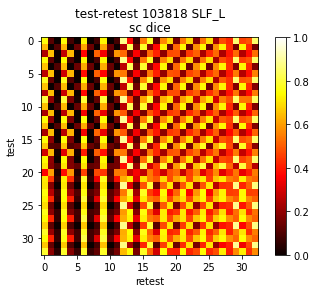

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.755049,0.114275,0.000000,0.752750,0.088012,0.000000,0.733114,0.000000,0.080817,0.737407,0.000461,0.088375,0.880636,0.375941,0.074307,0.547958,0.778156,0.123156,0.568608,0.691936,0.161620,0.545007,0.688304,0.187845,0.537129,0.697407,0.228995,0.477412,0.425339,0.856928,0.460977,0.488489,0.848482
1,0.641331,0.000313,0.108079,0.633435,0.000323,0.145389,0.611283,0.145389,0.000118,0.616726,0.141858,0.003974,0.251555,0.833345,0.156286,0.784521,0.184478,0.374288,0.730893,0.125236,0.521424,0.735702,0.131900,0.579784,0.735003,0.139657,0.578613,0.731537,0.434085,0.161103,0.735792,0.426385,0.158879
2,0.249680,0.654798,0.000919,0.275637,0.642310,0.000910,0.370200,0.000910,0.512373,0.349573,0.082652,0.591820,0.522847,0.154729,0.361512,0.164934,0.521505,0.415105,0.196597,0.475007,0.481927,0.187657,0.451284,0.510992,0.235523,0.429116,0.519990,0.238890,0.394689,0.519555,0.249610,0.380346,0.529767
3,0.751475,0.122824,0.000000,0.749623,0.097075,0.000000,0.732004,0.000000,0.086790,0.735306,0.000695,0.096786,0.880852,0.374664,0.079220,0.545584,0.777845,0.127810,0.566170,0.691423,0.166217,0.542539,0.688013,0.192500,0.535242,0.696999,0.232727,0.476880,0.428184,0.855442,0.460850,0.490865,0.846858
4,0.652905,0.000762,0.107531,0.644964,0.000642,0.144659,0.622459,0.144659,0.000467,0.627998,0.141162,0.004302,0.267434,0.833734,0.155868,0.787091,0.199749,0.373424,0.735125,0.138255,0.520089,0.738532,0.145591,0.578183,0.737546,0.153535,0.577197,0.732948,0.436010,0.179434,0.737184,0.428442,0.177775
5,0.264806,0.652969,0.000918,0.290413,0.639141,0.000909,0.383480,0.000909,0.510500,0.363514,0.082467,0.587907,0.543592,0.155375,0.359402,0.170458,0.539750,0.413696,0.204822,0.489671,0.480264,0.193789,0.467212,0.509137,0.240381,0.445620,0.519786,0.240860,0.396511,0.545046,0.251286,0.382873,0.555982
6,0.775933,0.130216,0.000000,0.774520,0.102608,0.000000,0.757341,0.000000,0.089629,0.760849,0.001232,0.099152,0.887848,0.404495,0.082543,0.571647,0.785469,0.133877,0.589526,0.698362,0.175961,0.566379,0.693993,0.203665,0.560084,0.701927,0.244699,0.502206,0.439243,0.857657,0.486762,0.501385,0.848686
7,0.655024,0.000932,0.107236,0.647076,0.000817,0.144266,0.624525,0.144266,0.000660,0.630078,0.140788,0.004483,0.270339,0.833226,0.155646,0.788347,0.202048,0.371202,0.736494,0.140603,0.516721,0.739934,0.147787,0.574570,0.738936,0.155706,0.573588,0.733787,0.434501,0.183502,0.738044,0.427126,0.182041
8,0.257801,0.651853,0.000924,0.283151,0.640052,0.000915,0.376527,0.000915,0.511663,0.356390,0.082568,0.590073,0.533559,0.155176,0.358137,0.169928,0.529248,0.411599,0.204222,0.479405,0.478086,0.193153,0.458011,0.506140,0.239174,0.436888,0.516251,0.239887,0.389534,0.537180,0.250033,0.375249,0.549376
9,0.802331,0.193794,0.019044,0.802609,0.165516,0.019463,0.800031,0.019463,0.130400,0.798987,0.024019,0.150711,0.892901,0.450796,0.133644,0.612550,0.791500,0.188333,0.630989,0.705591,0.234482,0.608879,0.702160,0.262814,0.609142,0.709484,0.299107,0.554769,0.481975,0.849421,0.542541,0.538011,0.840628


'[(18, 12)] 0.8951333663102622 '

subbundles/HCP_test_retest/SLF_L/103818/01/SLF_L_mase_dice.png


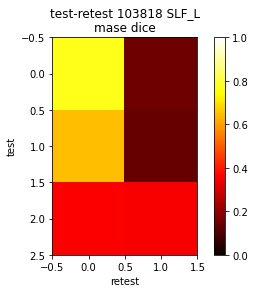

,0,1
0,0.773394,0.150751
1,0.650977,0.137403
2,0.361434,0.355721


'[(0, 0)] 0.773393949234183 '

subbundles/HCP_test_retest/SLF_R/103818/01/SLF_R_sc_dice.png


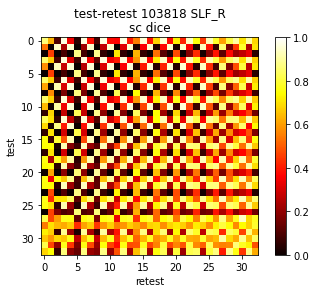

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.864201,0.634671,0.104874,0.965157,0.347517,0.043569,0.966764,0.383652,0.088630,0.967104,0.376713,0.369372,0.965722,0.401040,0.553885,0.957012,0.394102,0.686847,0.950839,0.377726,0.724914,0.414917,0.938144,0.754378,0.447680,0.926659,0.789052,0.606216,0.810407,0.907104,0.709867,0.902981,0.684166
1,0.537404,0.001734,0.942604,0.244976,0.956269,0.000000,0.224481,0.952138,0.000000,0.276123,0.952909,0.003450,0.322233,0.952145,0.028476,0.360234,0.951739,0.033637,0.373929,0.951463,0.027194,0.947653,0.356828,0.028148,0.933350,0.392517,0.064958,0.856875,0.162148,0.445393,0.788753,0.244976,0.704368
2,0.000701,0.458609,0.000000,0.093885,0.000000,0.876089,0.089588,0.000000,0.885253,0.061566,0.000000,0.715332,0.060325,0.000000,0.633349,0.063965,0.008459,0.531122,0.120539,0.026060,0.473218,0.010264,0.189328,0.426385,0.016193,0.188405,0.392073,0.126611,0.376957,0.215747,0.271098,0.336834,0.047350
3,0.849141,0.668816,0.089335,0.963441,0.322721,0.075542,0.965924,0.358606,0.121551,0.964859,0.352070,0.404645,0.962202,0.377359,0.587071,0.952242,0.370990,0.719525,0.944622,0.356054,0.757323,0.392869,0.933323,0.786318,0.426499,0.920500,0.818997,0.592096,0.836416,0.899070,0.702874,0.915827,0.678889
4,0.577225,0.005970,0.932378,0.281600,0.960858,0.000000,0.261307,0.958345,0.000000,0.314864,0.958748,0.005866,0.361047,0.958249,0.037934,0.398708,0.957427,0.046415,0.411791,0.955939,0.040785,0.953269,0.393991,0.043205,0.938690,0.429432,0.083495,0.865537,0.181306,0.482108,0.808222,0.269117,0.714609
5,0.000703,0.457420,0.000000,0.093634,0.000000,0.876840,0.089320,0.000000,0.886057,0.061220,0.000000,0.714921,0.059956,0.000000,0.632564,0.063575,0.008303,0.530023,0.120299,0.025953,0.471992,0.010113,0.189021,0.425031,0.016241,0.188338,0.390648,0.125120,0.375608,0.215531,0.269506,0.335740,0.047447
6,0.845874,0.675390,0.082173,0.961986,0.312483,0.073897,0.964839,0.348329,0.118028,0.964195,0.341711,0.407371,0.961124,0.367250,0.592389,0.950683,0.359988,0.726585,0.941825,0.345091,0.765236,0.381504,0.930211,0.794580,0.414227,0.917119,0.825603,0.583194,0.842750,0.894463,0.692920,0.917076,0.677135
7,0.606604,0.009156,0.921841,0.309131,0.962209,0.000000,0.289033,0.961520,0.000000,0.344685,0.960930,0.006352,0.392021,0.960543,0.040688,0.429557,0.959378,0.052498,0.441221,0.958054,0.048186,0.956451,0.421457,0.053288,0.942110,0.456896,0.095744,0.870617,0.192943,0.510401,0.823156,0.288480,0.719439
8,0.009767,0.567895,0.000000,0.170111,0.000000,0.869094,0.165193,0.000000,0.897987,0.102063,0.000471,0.825478,0.095005,0.000475,0.745413,0.096261,0.010680,0.633198,0.154804,0.028351,0.566974,0.016033,0.226211,0.513735,0.034910,0.218918,0.472294,0.163448,0.441841,0.236335,0.312542,0.389318,0.075324
9,0.847232,0.677797,0.077223,0.959120,0.306849,0.067115,0.962675,0.341951,0.103530,0.964642,0.333818,0.399019,0.962463,0.359403,0.589178,0.952135,0.348493,0.727777,0.940515,0.334825,0.768363,0.367546,0.927555,0.798907,0.396707,0.913730,0.829900,0.569881,0.847186,0.890879,0.678692,0.915875,0.671051


'[(0, 9)] 0.9671040853593039 '

subbundles/HCP_test_retest/SLF_R/103818/01/SLF_R_mase_dice.png


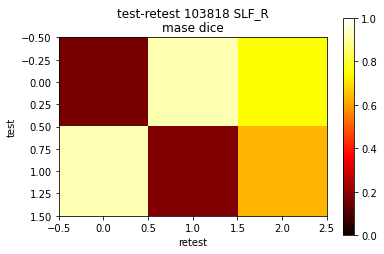

,0,1,2
0,0.164550,0.919190,0.749668
1,0.923966,0.175971,0.634856


'[(1, 0)] 0.9239660902856662 '

subbundles/HCP_test_retest/SLF_L/105923/01/SLF_L_sc_dice.png


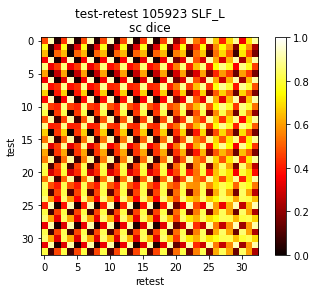

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.474361,0.925648,0.046678,0.444376,0.929137,0.046678,0.474361,0.925648,0.046678,0.473037,0.940885,0.046678,0.476199,0.940089,0.046678,0.446359,0.941631,0.046678,0.462166,0.934133,0.201961,0.436385,0.927685,0.544176,0.419865,0.910722,0.667660,0.414543,0.692792,0.897919,0.346092,0.703135,0.907511
1,0.767958,0.069826,0.315728,0.769188,0.071507,0.315728,0.767958,0.069826,0.315728,0.769324,0.079494,0.315728,0.767706,0.077401,0.315728,0.768936,0.079119,0.315728,0.766168,0.115401,0.387507,0.754311,0.198761,0.440240,0.753276,0.210978,0.566593,0.748649,0.594441,0.177557,0.750204,0.584702,0.239756
2,0.640020,0.003463,0.515148,0.641342,0.004603,0.515148,0.640020,0.003463,0.515148,0.641042,0.025279,0.515148,0.638662,0.025285,0.515148,0.639982,0.025568,0.515148,0.643441,0.023116,0.551488,0.653057,0.069003,0.528107,0.667276,0.088488,0.534855,0.691003,0.497299,0.079425,0.711636,0.474124,0.167753
3,0.358133,0.938788,0.027084,0.330681,0.939324,0.027084,0.358133,0.938788,0.027084,0.356980,0.940587,0.027084,0.360472,0.940488,0.027084,0.333152,0.940428,0.027084,0.345006,0.938446,0.162673,0.321088,0.934930,0.490815,0.304679,0.920480,0.616595,0.296936,0.639478,0.916355,0.229387,0.650142,0.913736
4,0.863794,0.345754,0.451165,0.859822,0.351657,0.451165,0.863794,0.345754,0.451165,0.864060,0.382823,0.451165,0.863278,0.380504,0.451165,0.859323,0.384493,0.451165,0.865041,0.374711,0.558188,0.861358,0.414552,0.652163,0.864642,0.405966,0.747582,0.873363,0.775232,0.360759,0.873367,0.772262,0.459452
5,0.608986,0.020649,0.276937,0.610364,0.021008,0.276937,0.608986,0.020649,0.276937,0.611143,0.023116,0.276937,0.608644,0.023253,0.276937,0.610022,0.023282,0.276937,0.610017,0.068311,0.301148,0.606902,0.145360,0.315626,0.607678,0.166667,0.420178,0.596972,0.457159,0.141552,0.602270,0.450854,0.164461
6,0.348715,0.939366,0.026628,0.321424,0.939747,0.026628,0.348715,0.939366,0.026628,0.347720,0.940190,0.026628,0.351234,0.940089,0.026628,0.324077,0.940003,0.026628,0.335491,0.938452,0.160036,0.311229,0.935106,0.487244,0.294714,0.921176,0.613750,0.287024,0.636672,0.917509,0.220726,0.647342,0.913012
7,0.886835,0.383561,0.437431,0.882584,0.389573,0.437431,0.886835,0.383561,0.437431,0.887045,0.421019,0.437431,0.886921,0.417891,0.437431,0.882689,0.421869,0.437431,0.888437,0.412293,0.548880,0.884559,0.451359,0.651130,0.886091,0.442522,0.757668,0.890251,0.794690,0.393034,0.887112,0.795672,0.488093
8,0.677199,0.019610,0.401189,0.678720,0.020001,0.401189,0.677199,0.019610,0.401189,0.679512,0.023060,0.401189,0.676765,0.023195,0.401189,0.678285,0.023223,0.401189,0.678871,0.067347,0.421961,0.678095,0.145412,0.418089,0.681632,0.166227,0.498215,0.675172,0.521703,0.143515,0.683073,0.508356,0.176680
9,0.386221,0.938370,0.032505,0.359074,0.938883,0.032505,0.386221,0.938370,0.032505,0.384967,0.940205,0.032505,0.388361,0.940104,0.032505,0.361348,0.940096,0.032505,0.372117,0.938181,0.168523,0.344953,0.934855,0.501207,0.328308,0.921244,0.628133,0.322035,0.649582,0.917462,0.255150,0.660076,0.916539


'[(0, 16)] 0.9416307558223986 '

subbundles/HCP_test_retest/SLF_L/105923/01/SLF_L_mase_dice.png


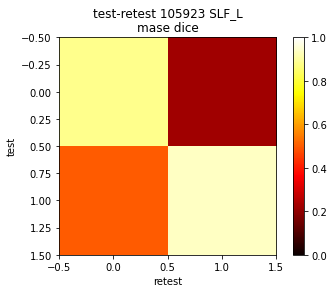

,0,1
0,0.885803,0.223139
1,0.502592,0.938280


'[(1, 1)] 0.9382799090782576 '

subbundles/HCP_test_retest/SLF_R/105923/01/SLF_R_sc_dice.png


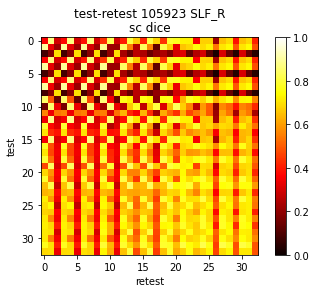

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.361044,0.872787,0.300694,0.372427,0.873787,0.300694,0.387903,0.869494,0.300694,0.434620,0.826883,0.300694,0.406628,0.811782,0.671729,0.414166,0.808003,0.680248,0.442234,0.791878,0.776916,0.727252,0.726365,0.357942,0.675976,0.675997,0.225076,0.655505,0.691535,0.389175,0.655921,0.688465,0.414616
1,0.900068,0.332782,0.217966,0.898517,0.324874,0.217966,0.897419,0.304701,0.217966,0.887775,0.219022,0.217966,0.842186,0.554510,0.258211,0.836542,0.566284,0.129081,0.817891,0.673786,0.332984,0.656993,0.686156,0.755875,0.693454,0.727545,0.546060,0.708754,0.740007,0.493366,0.708146,0.742973,0.481126
2,0.089546,0.187434,0.702226,0.089206,0.190706,0.702226,0.088975,0.193953,0.702226,0.088855,0.205719,0.702226,0.236819,0.144176,0.263773,0.242395,0.143863,0.203995,0.245084,0.175463,0.299516,0.322663,0.135821,0.252511,0.303930,0.122742,0.026989,0.309261,0.143200,0.042499,0.308507,0.136509,0.046594
3,0.370303,0.872451,0.300167,0.381691,0.873311,0.300167,0.397005,0.868847,0.300167,0.443220,0.824795,0.300167,0.415547,0.812770,0.669555,0.422956,0.808969,0.677158,0.450995,0.793356,0.775931,0.729830,0.728911,0.366039,0.679855,0.678995,0.232348,0.659633,0.694619,0.393900,0.660110,0.691614,0.419034
4,0.899664,0.330355,0.218000,0.897949,0.322516,0.218000,0.896762,0.302523,0.218000,0.887017,0.217994,0.218000,0.841785,0.552405,0.258089,0.836129,0.564215,0.129124,0.817389,0.672137,0.331629,0.655799,0.684438,0.755989,0.692326,0.726027,0.546345,0.707758,0.738496,0.494207,0.707108,0.741546,0.481907
5,0.089546,0.187434,0.702226,0.089206,0.190706,0.702226,0.088975,0.193953,0.702226,0.088855,0.205719,0.702226,0.236819,0.144176,0.263773,0.242395,0.143863,0.203995,0.245084,0.175463,0.299516,0.322663,0.135821,0.252511,0.303930,0.122742,0.026989,0.309261,0.143200,0.042499,0.308507,0.136509,0.046594
6,0.365431,0.872386,0.302479,0.376498,0.873381,0.302479,0.391894,0.868987,0.302479,0.438453,0.826290,0.302479,0.411439,0.811334,0.672959,0.418916,0.807537,0.680984,0.447261,0.791531,0.778068,0.728713,0.726292,0.363479,0.678131,0.675952,0.230287,0.657504,0.691677,0.392929,0.657884,0.688850,0.418292
7,0.899720,0.344597,0.216661,0.898889,0.336320,0.216661,0.898239,0.315932,0.216661,0.890265,0.228706,0.216661,0.841721,0.563411,0.262304,0.836204,0.574943,0.134312,0.817641,0.681632,0.337311,0.661766,0.692246,0.754369,0.698728,0.732038,0.544105,0.713109,0.744451,0.495023,0.712859,0.746661,0.483211
8,0.089546,0.187434,0.702226,0.089206,0.190706,0.702226,0.088975,0.193953,0.702226,0.088855,0.205719,0.702226,0.236819,0.144176,0.263773,0.242395,0.143863,0.203995,0.245084,0.175463,0.299516,0.322663,0.135821,0.252511,0.303930,0.122742,0.026989,0.309261,0.143200,0.042499,0.308507,0.136509,0.046594
9,0.846446,0.496993,0.135184,0.850269,0.489217,0.135184,0.854738,0.466368,0.135184,0.860497,0.348348,0.135184,0.768525,0.729624,0.256907,0.764105,0.731368,0.188575,0.757908,0.768089,0.370378,0.637750,0.780423,0.741370,0.682673,0.780646,0.626695,0.707568,0.762813,0.580052,0.730971,0.740064,0.566712


'[(1, 0)] 0.9000675619614305 '

subbundles/HCP_test_retest/SLF_R/105923/01/SLF_R_mase_dice.png


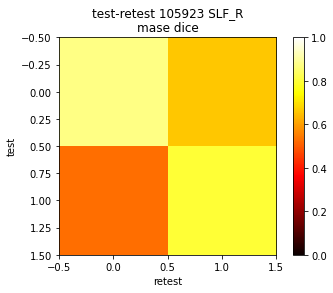

,0,1
0,0.875309,0.663025
1,0.527734,0.799011


'[(0, 0)] 0.8753086734044448 '

In [328]:
dice_matricies = {}

for subject in subjects:
    dice_matricies[subject] = {}
    for bundle_name in bundle_names:
        dice_matricies[subject][bundle_name] = {}
        target_dir = target_dirs[subject][bundle_name]
        
        for model_type in model_types:
            num_test_clusters = 0

            for ids, model_name in zip(cluster_ids[subject][bundle_name]['test'], model_names[subject][bundle_name]['test']):
                if model_name.startswith(model_type):
                    num_test_clusters += len(ids)

            num_retest_clusters = 0

            for ids, model_name in zip(cluster_ids[subject][bundle_name]['retest'], model_names[subject][bundle_name]['retest']):
                if model_name.startswith(model_type):
                    num_retest_clusters += len(ids)

            dice_matrix = np.zeros((num_test_clusters, num_retest_clusters))

            ii=0
            jj=0

            for test_model_name in cluster_masks[subject][bundle_name]['test'][model_type]:
                for test_cluster_id in cluster_masks[subject][bundle_name]['test'][model_type][test_model_name]:
                    test_cluster_mask = cluster_masks[subject][bundle_name]['test'][model_type][test_model_name][test_cluster_id]
                    for retest_model_name in cluster_masks[subject][bundle_name]['retest'][model_type]:
                        for retest_cluster_id in cluster_masks[subject][bundle_name]['retest'][model_type][retest_model_name]:
                            retest_cluster_mask = cluster_masks[subject][bundle_name]['retest'][model_type][retest_model_name][retest_cluster_id]
#                             dice_matrix[ii][jj] = 1-dice(test_cluster_mask.flatten(), retest_cluster_mask.flatten())
                            dice_matrix[ii][jj] = dice_coeff(test_cluster_mask, retest_cluster_mask)
                            jj+=1
                    ii+=1
                    jj=0

            dice_matricies[subject][bundle_name][model_type] = dice_matrix
            
            plt.figure()
            plt.title(f'test-retest {subject} {bundle_name}\n{model_type} dice')
            plt.imshow(dice_matrix, cmap='hot', interpolation='nearest', vmin=0., vmax=1.)
            plt.colorbar()
            plt.ylabel('test')
            plt.xlabel('retest')
            f_name = op.join(target_dir, f'{bundle_name}_{model_type}_dice.png')
            print(f_name)
            plt.savefig(f_name)
            plt.show()

            with pd.option_context('display.max_colwidth', -1, 'display.max_columns', num_retest_clusters):
                display(pd.DataFrame(dice_matrix))

            display(f'{[tuple(i) for i in np.argwhere(dice_matrix==np.amax(dice_matrix)).tolist()]} {np.amax(dice_matrix)} ')

## density maps

- Stack by cluster id; show where all clusters overlap

**NOTE:currently assumes same number of clusters for test retest**

- Stack all test-retest cluster pairs (max of 2)

## profile reliability

bundle fa r2

In [382]:
from sklearn.metrics import r2_score

test_retest_bundle_profile_fa_r2 = {}

for subject in subjects:
    test_retest_bundle_profile_fa_r2[subject] = {}
    
    loc_test  = get_iloc(myafq_test, subject)
    loc_retest = get_iloc(myafq_retest, subject)

    fa_scalar_data_test = nib.load(get_scalar_filename(myafq_test, 'dti_fa', loc_test)).get_fdata()
    fa_scalar_data_retest = nib.load(get_scalar_filename(myafq_retest, 'dti_fa', loc_retest)).get_fdata()

    for bundle_name in bundle_names:        
        test_fa = afq_profile(
            fa_scalar_data_test,
            tractograms[subject][bundle_name]['test'].streamlines,
            tractograms[subject][bundle_name]['test'].affine,
            weights=gaussian_weights(tractograms[subject][bundle_name]['test'].streamlines)
        )

        retest_fa = afq_profile(
            fa_scalar_data_retest,
            tractograms[subject][bundle_name]['retest'].streamlines,
            tractograms[subject][bundle_name]['retest'].affine,
            weights=gaussian_weights(tractograms[subject][bundle_name]['retest'].streamlines)
        )

        test_retest_bundle_profile_fa_r2[subject][bundle_name] = r2_score(test_fa, retest_fa)
        
display(pd.DataFrame(test_retest_bundle_profile_fa_r2))

,103818,105923
SLF_L,0.841389,0.914186
SLF_R,0.912328,0.895930


In [304]:
cluster_profiles = {}

for subject in subjects:
    cluster_profiles[subject] = {}
    
    loc_test  = get_iloc(myafq_test, subject)
    loc_retest = get_iloc(myafq_retest, subject)
    
    fa_scalar_data_test = nib.load(get_scalar_filename(myafq_test, 'dti_fa', loc_test)).get_fdata()
    fa_scalar_data_retest = nib.load(get_scalar_filename(myafq_retest, 'dti_fa', loc_retest)).get_fdata()
    
    for bundle_name in bundle_names:
        cluster_profiles[subject][bundle_name] = {}
                    
        for ses, fa_scalar_data in zip(test_retest_sessions, [fa_scalar_data_test, fa_scalar_data_retest]):
            cluster_profiles[subject][bundle_name][ses] = {}

            for model_type in model_types:
                cluster_profiles[subject][bundle_name][ses][model_type] = {}

                for ids, idx, model_name in zip(cluster_ids[subject][bundle_name][ses], clusters[subject][bundle_name][ses], model_names[subject][bundle_name][ses]):
                    if not model_name.startswith(model_type):
                        continue
                        
                    cluster_profiles[subject][bundle_name][ses][model_type][model_name] = {}

                    for i in ids:
                        cluster_streamlines = tractograms[subject][bundle_name][ses].streamlines[idx[i]]
                        cluster_affine = tractograms[subject][bundle_name][ses].affine
                        
                        profile = afq_profile(
                            fa_scalar_data,
                            cluster_streamlines,
                            cluster_affine,
                            weights=gaussian_weights(cluster_streamlines)
                        )
                        
                        cluster_profiles[subject][bundle_name][ses][model_type][model_name][i] = profile

subbundles/HCP_test_retest/SLF_L/103818/01/SLF_L_sc_profile_corr.png


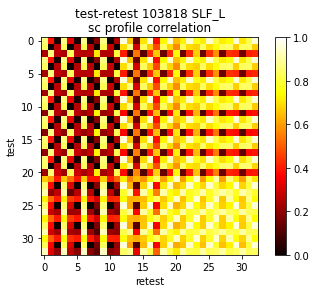

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.870599,0.387132,0.022961,0.872917,0.326249,0.023091,0.879463,0.023091,0.180656,0.879064,-0.005062,0.237778,0.961619,0.667420,0.142798,0.710208,0.955453,0.384448,0.737769,0.941459,0.652098,0.723671,0.944137,0.767083,0.722627,0.945183,0.812455,0.719994,0.753625,0.960844,0.717073,0.821651,0.960550
1,0.836320,-0.103935,0.259260,0.833493,-0.165012,0.255357,0.825830,0.255357,-0.263956,0.825375,0.281579,-0.204662,0.697548,0.871262,0.302653,0.842503,0.675543,0.470360,0.837535,0.690227,0.572280,0.835818,0.698039,0.675861,0.836560,0.701727,0.753368,0.835500,0.849415,0.674359,0.837962,0.845866,0.672363
2,0.237363,0.868647,0.264040,0.240641,0.833427,0.263374,0.255312,0.263374,0.717201,0.251349,0.250772,0.806217,0.402347,0.070978,0.540350,0.118635,0.424567,0.667853,0.147777,0.423434,0.745313,0.141721,0.428708,0.675466,0.144289,0.430682,0.581299,0.148419,0.436987,0.425503,0.150331,0.411158,0.425662
3,0.870721,0.386017,0.021145,0.873030,0.325371,0.021348,0.879521,0.021348,0.180120,0.879138,-0.006786,0.236681,0.961334,0.667559,0.140845,0.710284,0.955037,0.382736,0.737853,0.941024,0.650432,0.723759,0.943662,0.765395,0.722725,0.944683,0.811069,0.720107,0.752629,0.960343,0.717156,0.820963,0.960015
4,0.837155,-0.102949,0.260109,0.834332,-0.164138,0.256187,0.826717,0.256187,-0.263345,0.826257,0.282306,-0.203715,0.698248,0.872068,0.303582,0.843442,0.676230,0.471231,0.838499,0.690825,0.573368,0.836779,0.698692,0.676978,0.837524,0.702412,0.754340,0.836450,0.850095,0.675111,0.838925,0.846466,0.673161
5,0.234273,0.869283,0.263950,0.237552,0.834237,0.263189,0.252155,0.263189,0.719041,0.248226,0.250679,0.806770,0.400003,0.067807,0.539440,0.115487,0.422589,0.666198,0.144585,0.421595,0.742797,0.138565,0.426726,0.673038,0.141098,0.428643,0.578938,0.145253,0.434928,0.423050,0.147129,0.409188,0.423044
6,0.869018,0.384981,0.021870,0.871347,0.324060,0.022100,0.877906,0.022100,0.178018,0.877512,-0.006265,0.235087,0.960578,0.665400,0.141164,0.708091,0.954233,0.383249,0.735682,0.940205,0.650951,0.721536,0.942820,0.766212,0.720506,0.943814,0.811684,0.717859,0.752138,0.959938,0.714944,0.820013,0.959705
7,0.837304,-0.101087,0.263441,0.834500,-0.162493,0.259382,0.827003,0.259382,-0.262467,0.826519,0.285416,-0.202084,0.698561,0.872337,0.306857,0.843620,0.676539,0.474125,0.838658,0.691241,0.576029,0.836928,0.699188,0.679544,0.837685,0.702940,0.756478,0.836543,0.851409,0.675956,0.839114,0.846887,0.674224
8,0.225954,0.870671,0.261799,0.229246,0.836510,0.261245,0.243899,0.261245,0.722480,0.239971,0.248598,0.809520,0.393073,0.059065,0.537316,0.106946,0.416105,0.662550,0.136132,0.414924,0.737398,0.130152,0.419964,0.665843,0.132716,0.421836,0.570865,0.136936,0.426797,0.416204,0.138776,0.401224,0.416138
9,0.867493,0.391207,0.028475,0.869941,0.329943,0.028481,0.876818,0.028481,0.181964,0.876335,-0.000452,0.241277,0.957300,0.666103,0.149180,0.708524,0.949762,0.389883,0.735871,0.935601,0.657779,0.721850,0.938562,0.772612,0.720867,0.939744,0.816530,0.718133,0.751829,0.957778,0.715467,0.817003,0.958349


subbundles/HCP_test_retest/SLF_L/103818/01/SLF_L_mase_profile_corr.png


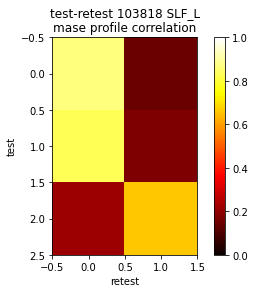

,0,1
0,0.869966,0.146360
1,0.829854,0.174373
2,0.220365,0.664050


subbundles/HCP_test_retest/SLF_R/103818/01/SLF_R_sc_profile_corr.png


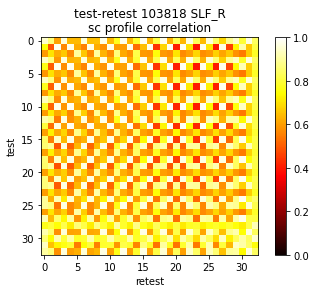

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.950636,0.864332,0.606042,0.962991,0.643686,0.643396,0.959803,0.650526,0.654724,0.974078,0.644204,0.773720,0.980131,0.642419,0.792277,0.983936,0.638335,0.812672,0.977008,0.633188,0.825642,0.640240,0.970137,0.834308,0.646863,0.962342,0.848458,0.690293,0.885007,0.947710,0.797461,0.966468,0.842647
1,0.753335,0.494419,0.984177,0.569553,0.978037,0.618742,0.557923,0.976041,0.623854,0.579891,0.977410,0.598789,0.598571,0.977611,0.529938,0.650110,0.979374,0.440632,0.687491,0.982458,0.406436,0.981439,0.700478,0.393072,0.980169,0.710904,0.402268,0.972655,0.458889,0.730837,0.913544,0.663773,0.813572
2,0.594410,0.703608,0.623081,0.666472,0.573051,0.900549,0.662707,0.572505,0.905528,0.633740,0.577899,0.868587,0.617437,0.584057,0.820172,0.596027,0.587215,0.754129,0.594768,0.580684,0.710747,0.573140,0.605046,0.685191,0.577995,0.595853,0.677136,0.612153,0.667934,0.584243,0.549500,0.668358,0.784772
3,0.943066,0.869675,0.593422,0.966380,0.629187,0.642566,0.963642,0.635949,0.654081,0.976509,0.629705,0.777125,0.981451,0.627978,0.798115,0.982446,0.623982,0.821262,0.973182,0.618864,0.834926,0.625803,0.965442,0.843827,0.632486,0.956551,0.857496,0.677256,0.892112,0.940034,0.784086,0.965500,0.840121
4,0.763187,0.500824,0.983638,0.576322,0.982282,0.618086,0.564600,0.980760,0.622904,0.587307,0.981688,0.597961,0.606420,0.981680,0.530394,0.658450,0.983027,0.443181,0.696148,0.985612,0.410510,0.985094,0.709028,0.397868,0.984103,0.719723,0.407809,0.977142,0.465454,0.740540,0.923122,0.670479,0.816361
5,0.590567,0.699570,0.621948,0.662383,0.571255,0.898539,0.658600,0.570624,0.903568,0.629438,0.576084,0.866785,0.613101,0.582258,0.818065,0.591733,0.585492,0.751453,0.590619,0.579095,0.707482,0.571490,0.601060,0.681591,0.576278,0.591964,0.673241,0.610179,0.663588,0.580458,0.546645,0.664232,0.781334
6,0.937967,0.871598,0.584623,0.967740,0.619468,0.640638,0.965285,0.626183,0.652215,0.977564,0.619990,0.777095,0.981923,0.618287,0.799631,0.981327,0.614330,0.824720,0.970669,0.609210,0.839060,0.616079,0.962381,0.848264,0.622777,0.952787,0.861783,0.668238,0.895509,0.935026,0.774934,0.964515,0.837466
7,0.770760,0.506418,0.982385,0.582102,0.984541,0.616736,0.570353,0.983400,0.621402,0.593583,0.983921,0.597408,0.613026,0.983716,0.531078,0.665263,0.984753,0.445756,0.702893,0.987075,0.414386,0.987029,0.715499,0.402391,0.986269,0.726377,0.412880,0.979886,0.471207,0.747855,0.930656,0.675613,0.817583
8,0.593554,0.704465,0.623074,0.666754,0.572748,0.897190,0.662999,0.572115,0.902696,0.633384,0.577575,0.870957,0.616928,0.583735,0.823037,0.595384,0.586954,0.756763,0.594126,0.580524,0.712668,0.572940,0.604641,0.686496,0.577759,0.595388,0.678012,0.612016,0.668110,0.583578,0.548401,0.668262,0.784924
9,0.933653,0.869060,0.575666,0.966369,0.610990,0.634240,0.964145,0.617719,0.645656,0.977270,0.611418,0.768894,0.981774,0.609584,0.792660,0.980563,0.605579,0.820382,0.968720,0.600585,0.836414,0.607584,0.959612,0.846612,0.614214,0.949456,0.860723,0.659610,0.895051,0.930842,0.768185,0.962045,0.831008


subbundles/HCP_test_retest/SLF_R/103818/01/SLF_R_mase_profile_corr.png


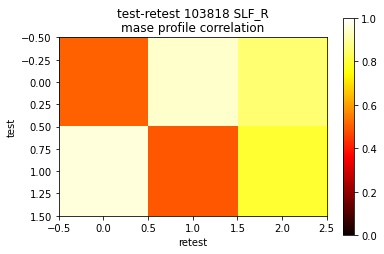

,0,1,2
0,0.509210,0.946782,0.857172
1,0.963902,0.493698,0.793549


subbundles/HCP_test_retest/SLF_L/105923/01/SLF_L_sc_profile_corr.png


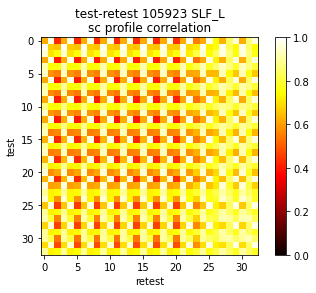

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.622425,0.974980,0.428126,0.621755,0.974750,0.428126,0.622425,0.974980,0.428126,0.620750,0.974858,0.428126,0.622295,0.975081,0.428126,0.621658,0.974855,0.428126,0.622259,0.975912,0.437976,0.618172,0.977166,0.552098,0.620713,0.972395,0.743227,0.631834,0.843633,0.967410,0.627880,0.862354,0.964848
1,0.984515,0.672369,0.657141,0.984449,0.672933,0.657141,0.984515,0.672369,0.657141,0.984421,0.672486,0.657141,0.984594,0.671005,0.657141,0.984537,0.671473,0.657141,0.984333,0.674227,0.664818,0.983534,0.695683,0.722378,0.982139,0.726130,0.750785,0.978128,0.825252,0.738961,0.975337,0.841506,0.748005
2,0.954764,0.703881,0.754081,0.954200,0.704557,0.754081,0.954764,0.703881,0.754081,0.953888,0.704581,0.754081,0.954765,0.702885,0.754081,0.954159,0.703482,0.754081,0.954632,0.705085,0.760827,0.955682,0.721452,0.813626,0.957219,0.745774,0.838617,0.963198,0.869681,0.751898,0.961317,0.871039,0.763703
3,0.620066,0.969187,0.407944,0.619476,0.968827,0.407944,0.620066,0.969187,0.407944,0.618529,0.968933,0.407944,0.619957,0.969281,0.407944,0.619403,0.968920,0.407944,0.619954,0.970451,0.417286,0.615654,0.972860,0.531444,0.617986,0.968724,0.725562,0.628504,0.830869,0.964936,0.625063,0.850363,0.961632
4,0.921628,0.748232,0.755853,0.920746,0.749118,0.755853,0.921628,0.748232,0.755853,0.920193,0.749041,0.755853,0.921638,0.747238,0.755853,0.920708,0.748064,0.755853,0.921402,0.748524,0.764413,0.922947,0.761321,0.819700,0.925075,0.783930,0.849725,0.934183,0.874581,0.788988,0.930141,0.875398,0.801119
5,0.939014,0.585610,0.556331,0.939529,0.585892,0.556331,0.939014,0.585610,0.556331,0.939788,0.585333,0.556331,0.939055,0.584187,0.556331,0.939610,0.584362,0.556331,0.939244,0.588404,0.562525,0.938299,0.613471,0.618791,0.936682,0.644465,0.644221,0.926179,0.738917,0.660766,0.925408,0.763020,0.667162
6,0.619993,0.968767,0.407035,0.619410,0.968396,0.407035,0.619993,0.968767,0.407035,0.618466,0.968503,0.407035,0.619885,0.968861,0.407035,0.619337,0.968490,0.407035,0.619884,0.970054,0.416326,0.615568,0.972557,0.530423,0.617887,0.968464,0.724582,0.628348,0.830166,0.964759,0.624939,0.849706,0.961407
7,0.905897,0.747987,0.752330,0.904906,0.748921,0.752330,0.905897,0.747987,0.752330,0.904293,0.748812,0.752330,0.905917,0.746980,0.752330,0.904874,0.747861,0.752330,0.905536,0.747927,0.761021,0.907002,0.759498,0.814318,0.908941,0.781851,0.843729,0.918566,0.867100,0.786434,0.913698,0.867641,0.798784
8,0.927509,0.570341,0.544375,0.928124,0.570583,0.544375,0.927509,0.570341,0.544375,0.928460,0.570113,0.544375,0.927550,0.569032,0.544375,0.928205,0.569160,0.544375,0.927974,0.573536,0.550531,0.927443,0.598933,0.610116,0.926476,0.628447,0.638606,0.916503,0.729408,0.644240,0.917060,0.752235,0.650039
9,0.619336,0.968325,0.405462,0.618761,0.967945,0.405462,0.619336,0.968325,0.405462,0.617818,0.968065,0.405462,0.619226,0.968433,0.405462,0.618686,0.968053,0.405462,0.619229,0.969656,0.414716,0.614879,0.972184,0.529214,0.617241,0.967912,0.724297,0.627758,0.830041,0.964103,0.624441,0.849504,0.960737


subbundles/HCP_test_retest/SLF_L/105923/01/SLF_L_mase_profile_corr.png


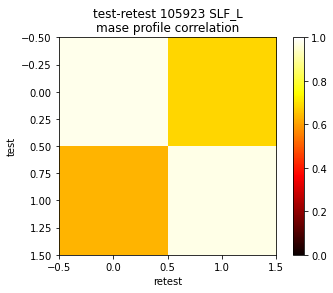

,0,1
0,0.977808,0.686532
1,0.633019,0.973945


subbundles/HCP_test_retest/SLF_R/105923/01/SLF_R_sc_profile_corr.png


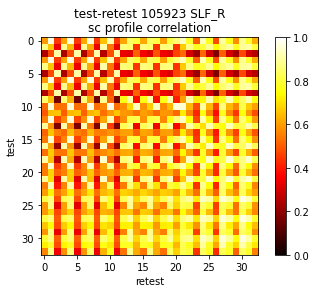

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.596709,0.968617,0.447891,0.605953,0.964553,0.447891,0.615992,0.958782,0.447891,0.653141,0.922122,0.447891,0.611571,0.843913,0.808151,0.618232,0.836173,0.813725,0.605363,0.806063,0.860279,0.938851,0.786760,0.502264,0.930188,0.773950,0.479472,0.906269,0.776412,0.576513,0.889069,0.792821,0.623628
1,0.882109,0.663314,0.341059,0.888346,0.643362,0.341059,0.894440,0.624546,0.341059,0.913696,0.541247,0.341059,0.865495,0.854326,0.441110,0.868825,0.855268,0.437119,0.863478,0.875751,0.439445,0.670145,0.878316,0.775359,0.801785,0.885991,0.745485,0.854636,0.896293,0.779697,0.895797,0.908294,0.801982
2,0.243124,0.475061,0.912604,0.245874,0.477711,0.912604,0.249445,0.476809,0.912604,0.260087,0.481954,0.912604,0.339579,0.323299,0.511575,0.351117,0.315587,0.491936,0.345099,0.316401,0.463243,0.526166,0.308333,0.215606,0.519504,0.296940,0.175409,0.506328,0.304216,0.230282,0.470118,0.308553,0.259376
3,0.597045,0.967670,0.446062,0.606331,0.963385,0.446062,0.616414,0.957415,0.446062,0.653723,0.919916,0.446062,0.610837,0.846205,0.804902,0.617484,0.838484,0.810467,0.604630,0.808323,0.857349,0.937206,0.788738,0.501520,0.929211,0.775666,0.478842,0.905535,0.778148,0.575636,0.888942,0.794274,0.622805
4,0.882107,0.662251,0.343656,0.888272,0.642448,0.343656,0.894296,0.623762,0.343656,0.913280,0.541078,0.343656,0.866941,0.851140,0.441905,0.870301,0.852078,0.437827,0.864944,0.872909,0.439673,0.670367,0.875806,0.776273,0.801906,0.883757,0.745925,0.854837,0.894117,0.780052,0.895551,0.906399,0.802178
5,0.243124,0.475061,0.912604,0.245874,0.477711,0.912604,0.249445,0.476809,0.912604,0.260087,0.481954,0.912604,0.339579,0.323299,0.511575,0.351117,0.315587,0.491936,0.345099,0.316401,0.463243,0.526166,0.308333,0.215606,0.519504,0.296940,0.175409,0.506328,0.304216,0.230282,0.470118,0.308553,0.259376
6,0.596142,0.968820,0.448778,0.605309,0.964956,0.448778,0.615290,0.959335,0.448778,0.652194,0.923378,0.448778,0.611418,0.841624,0.810375,0.618083,0.833828,0.815883,0.605215,0.803533,0.862241,0.939807,0.784396,0.502478,0.930338,0.771856,0.480127,0.906282,0.774333,0.577274,0.888535,0.791021,0.624321
7,0.881171,0.662647,0.339509,0.887503,0.642540,0.339509,0.893662,0.623627,0.339509,0.913209,0.539815,0.339509,0.864267,0.855467,0.439036,0.867600,0.856474,0.435132,0.862281,0.877086,0.437612,0.668716,0.879460,0.774011,0.800900,0.886910,0.743891,0.853766,0.897160,0.778032,0.895356,0.908973,0.800355
8,0.243124,0.475061,0.912604,0.245874,0.477711,0.912604,0.249445,0.476809,0.912604,0.260087,0.481954,0.912604,0.339579,0.323299,0.511575,0.351117,0.315587,0.491936,0.345099,0.316401,0.463243,0.526166,0.308333,0.215606,0.519504,0.296940,0.175409,0.506328,0.304216,0.230282,0.470118,0.308553,0.259376
9,0.849808,0.654674,0.155551,0.857139,0.631303,0.155551,0.864553,0.609682,0.155551,0.889229,0.512462,0.155551,0.768138,0.914907,0.378389,0.768478,0.916591,0.380784,0.764573,0.923935,0.405536,0.604528,0.918242,0.721883,0.731537,0.919146,0.706514,0.779016,0.925750,0.739529,0.838114,0.924497,0.763648


subbundles/HCP_test_retest/SLF_R/105923/01/SLF_R_mase_profile_corr.png


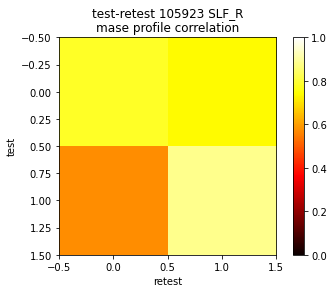

,0,1
0,0.784125,0.740864
1,0.574799,0.886003


In [305]:
profile_matricies = {}
for subject in subjects:
    profile_matricies[subject] = {}
    for bundle_name in bundle_names:
        profile_matricies[subject][bundle_name] = {}
        target_dir = target_dirs[subject][bundle_name]
        
        for model_type in model_types:
            num_test_clusters = 0

            for ids, model_name in zip(cluster_ids[subject][bundle_name]['test'], model_names[subject][bundle_name]['test']):
                if model_name.startswith(model_type):
                    num_test_clusters += len(ids)

            num_retest_clusters = 0

            for ids, model_name in zip(cluster_ids[subject][bundle_name]['retest'], model_names[subject][bundle_name]['retest']):
                if model_name.startswith(model_type):
                    num_retest_clusters += len(ids)

            profile_matrix = np.zeros((num_test_clusters, num_retest_clusters))

            ii=0
            jj=0
            
            for test_model_name in cluster_profiles[subject][bundle_name]['test'][model_type]:
                for test_cluster_id in cluster_profiles[subject][bundle_name]['test'][model_type][test_model_name]:
                    test_cluster_profile = cluster_profiles[subject][bundle_name]['test'][model_type][test_model_name][test_cluster_id]

                    for retest_model_name in cluster_profiles[subject][bundle_name]['retest'][model_type]:
                        for retest_cluster_id in cluster_profiles[subject][bundle_name]['retest'][model_type][retest_model_name]:
                            retest_cluster_profile = cluster_profiles[subject][bundle_name]['retest'][model_type][retest_model_name][retest_cluster_id]

#                             display(pd.DataFrame(zip(*[test_cluster_profile, retest_cluster_profile])))
                    
                            test_retest_corr_matrix = pd.DataFrame(zip(*[test_cluster_profile, retest_cluster_profile]), columns=['test', 'retest']).corr()

                            # select only the upper triangle off diagonals of the correlation matrix
                            test_retest_corr = test_retest_corr_matrix.where(np.triu(np.ones(test_retest_corr_matrix.shape), 1).astype(np.bool)).stack()

#                             print(subject, bundle_name, model_type, test_model_name, test_cluster_id, retest_model_name, retest_cluster_id, 'test-retest correlation:\n', test_retest_corr)
                            profile_matrix[ii][jj] = test_retest_corr
                            jj+=1
                    ii+=1
                    jj=0

            profile_matricies[subject][bundle_name][model_type] = profile_matrix
            
            plt.figure()
            plt.title(f'test-retest {subject} {bundle_name}\n{model_type} profile correlation')
            plt.imshow(profile_matrix, cmap='hot', interpolation='nearest', vmin=0., vmax=1.)
            plt.colorbar()
            plt.ylabel('test')
            plt.xlabel('retest')
            f_name = op.join(target_dir, f'{bundle_name}_{model_type}_profile_corr.png')
            print(f_name)
            plt.savefig(f_name)
            plt.show()

            with pd.option_context('display.max_colwidth', -1, 'display.max_columns', num_retest_clusters):
                display(pd.DataFrame(profile_matrix))



dice coefficient on diagonal (only compare same hyper parameters)

In [338]:
def find_best_clusters(dice_matrix, dice_pairs=None):
    ''' recursive function to find the best clusters based on dice coefficient scores '''    
    if dice_pairs is None:
        dice_pairs = []
    
    # ensure search modifies a copy
    _dice_matrix = dice_matrix.copy()

    # find the maximum dice coeffient
    idx = np.unravel_index(np.argmax(_dice_matrix, axis=None), _dice_matrix.shape)
    dice_pairs.append(idx)

    # remove the row and column from future considersation;
    # setting to minimum dice coefficient value
    _dice_matrix[idx[0], :] = 0
    _dice_matrix[:, idx[1]] = 0

    if (_dice_matrix == np.zeros(_dice_matrix.shape)).all():
        return dice_pairs
    else:
        return find_best_clusters(_dice_matrix, dice_pairs)

In [329]:
def number_of_models(subject, bundle_name, ses, model_type):
    num_models = 0

    for model_name in model_names[subject][bundle_name][ses]:
        if model_name.startswith(model_type):
            num_models += 1

    return num_models

In [333]:
def number_of_total_clusters(subject, bundle_name, ses, model_type):
    num_clusters = 0

    for ids, model_name in zip(cluster_ids[subject][bundle_name][ses], model_names[subject][bundle_name][ses]):
        if model_name.startswith(model_type):
            num_clusters += len(ids)

    return num_clusters

In [334]:
def number_of_clusters(subject, bundle_name, ses, model_type, model_idx):
    num_clusters = []

    for ids, model_name in zip(cluster_ids[subject][bundle_name][ses], model_names[subject][bundle_name][ses]):
        if model_name.startswith(model_type):
            num_clusters.append(len(ids))

    return num_clusters[model_idx]

In [369]:
summary_dfs = {}
for subject in subjects:
    summary_dfs[subject] = {}
    for bundle_name in bundle_names:
        df = pd.DataFrame(columns=["hyperparameter", "pair", "dice", "fa_r2"])

        for model_type in model_types:
            model_dice_matrix = dice_matricies[subject][bundle_name][model_type]
            profile_matrix = profile_matricies[subject][bundle_name][model_type]

            for model_num in range(number_of_models(subject, bundle_name, 'retest', model_type)):
                test_clusters = number_of_clusters(subject, bundle_name, 'test', model_type, model_num)
                retest_clusters = number_of_clusters(subject, bundle_name, 'retest', model_type, model_num)

                num_clusters = np.amin([test_clusters, retest_clusters])

                i = model_num*num_clusters
                j = i+num_clusters
                ij_slice = np.s_[i:j,i:j]

                dice_pairs = find_best_clusters(model_dice_matrix[ij_slice])

                for dice_pair in dice_pairs:
                    df = df.append({
                        "hyperparameter": f'{model_type} {model_num}',
                        "pair": dice_pair, 
                        "dice": model_dice_matrix[ij_slice][dice_pair],
                        "fa_r2": profile_matrix[ij_slice][dice_pair]
                    }, ignore_index=True)

        display(df)
        summary_dfs[subject][bundle_name] = df

,hyperparameter,pair,dice,fa_r2
0,sc 0,"(0, 0)",0.755049,0.870599
1,sc 0,"(2, 1)",0.654798,0.868647
2,sc 0,"(1, 2)",0.108079,0.259260
3,sc 1,"(0, 0)",0.749623,0.873030
4,sc 1,"(2, 1)",0.639141,0.834237
5,sc 1,"(1, 2)",0.144659,0.256187
6,sc 2,"(0, 0)",0.757341,0.877906
7,sc 2,"(2, 2)",0.511663,0.722480
8,sc 2,"(1, 1)",0.144266,0.259382
9,sc 3,"(0, 0)",0.798987,0.876335


,hyperparameter,pair,dice,fa_r2
0,sc 0,"(1, 2)",0.942604,0.984177
1,sc 0,"(0, 0)",0.864201,0.950636
2,sc 0,"(2, 1)",0.458609,0.703608
3,sc 1,"(0, 0)",0.963441,0.966380
4,sc 1,"(1, 1)",0.960858,0.982282
5,sc 1,"(2, 2)",0.876840,0.898539
6,sc 2,"(0, 0)",0.964839,0.965285
7,sc 2,"(1, 1)",0.961520,0.983400
8,sc 2,"(2, 2)",0.897987,0.902696
9,sc 3,"(0, 0)",0.964642,0.977270


,hyperparameter,pair,dice,fa_r2
0,sc 0,"(0, 1)",0.925648,0.974980
1,sc 0,"(1, 0)",0.767958,0.984515
2,sc 0,"(2, 2)",0.515148,0.754081
3,sc 1,"(0, 1)",0.939324,0.968827
4,sc 1,"(1, 0)",0.859822,0.920746
5,sc 1,"(2, 2)",0.276937,0.556331
6,sc 2,"(0, 1)",0.939366,0.968767
7,sc 2,"(1, 0)",0.886835,0.905897
8,sc 2,"(2, 2)",0.401189,0.544375
9,sc 3,"(0, 1)",0.940205,0.968065


,hyperparameter,pair,dice,fa_r2
0,sc 0,"(1, 0)",0.900068,0.882109
1,sc 0,"(0, 1)",0.872787,0.968617
2,sc 0,"(2, 2)",0.702226,0.912604
3,sc 1,"(1, 0)",0.897949,0.888272
4,sc 1,"(0, 1)",0.873311,0.963385
5,sc 1,"(2, 2)",0.702226,0.912604
6,sc 2,"(1, 0)",0.898239,0.893662
7,sc 2,"(0, 1)",0.868987,0.959335
8,sc 2,"(2, 2)",0.702226,0.912604
9,sc 3,"(1, 1)",0.870873,0.977550


MASE - special case only one model (not necessary anymore)

In [349]:
def getxticklabels():
    xticklabels = []
    num_models = number_of_models('103818', 'SLF_L', 'retest', 'sc')
    for i in range(num_models):
        test_clusters = number_of_clusters('103818', 'SLF_L', 'retest', 'sc', model_num)
        retest_clusters = number_of_clusters('103818', 'SLF_L', 'retest', 'sc', model_num)

        num_clusters = np.amin([test_clusters, retest_clusters])
        for j in range(num_clusters):
            xticklabels.append(j)

    test_clusters = number_of_clusters('103818', 'SLF_L', 'retest', 'mase', 0)
    retest_clusters = number_of_clusters('103818', 'SLF_L', 'retest', 'mase', 0)

    num_clusters = np.amin([test_clusters, retest_clusters])
    for j in range(num_clusters):
        xticklabels.append(j)
        
    return xticklabels

In [361]:
def getmodelxticklocations():
    xticklocations = []
    tot_num_clusters = 0
    for model_type in model_types:
        num_models = number_of_models('103818', 'SLF_L', 'retest', model_type)
        for model_num in range(num_models):
            test_clusters = number_of_clusters('103818', 'SLF_L', 'retest', model_type, model_num)
            retest_clusters = number_of_clusters('103818', 'SLF_L', 'retest', model_type, model_num)

            num_clusters = np.amin([test_clusters, retest_clusters])
            
            xticklocations.append(tot_num_clusters + np.median(range(num_clusters)))
            
            tot_num_clusters += num_clusters
            
    return xticklocations

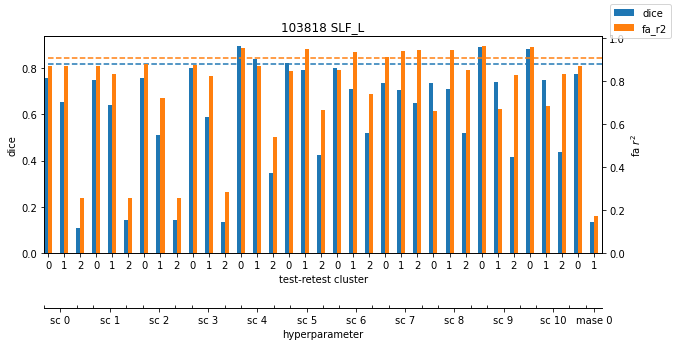

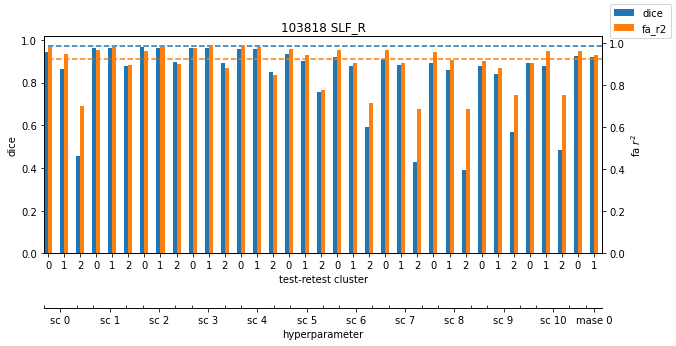

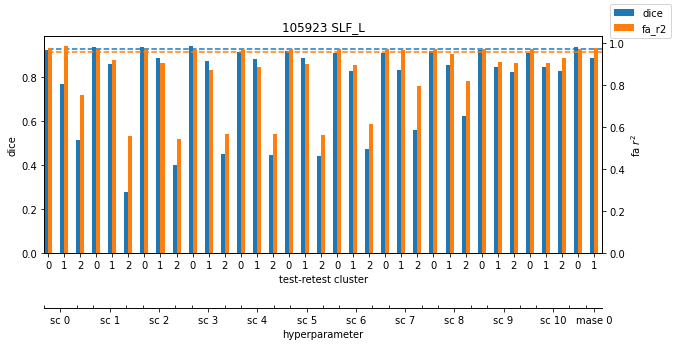

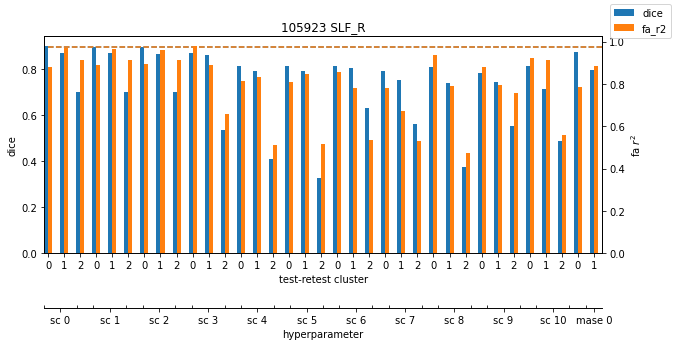

In [385]:
from matplotlib.ticker import MultipleLocator, FixedLocator

for subject in subjects:
    for bundle_name in bundle_names:
        df = summary_dfs[subject][bundle_name]
        fig, ax = plt.subplots(figsize=(10,4))
        ax2 = ax.twinx()

        df.dice.plot(kind='bar', color='tab:blue', ax=ax, width = 0.25, position=1)
        df.fa_r2.plot(kind='bar', color='tab:orange', ax=ax2, width = 0.25, position=0)
        ax.hlines(test_retest_dice_coef[subject][bundle_name], 0, len(df.index), colors='tab:blue', linestyles='dashed')
        ax.hlines(test_retest_bundle_profile_fa_r2[subject][bundle_name], 0, len(df.index), colors='tab:orange', linestyles='dashed')

        ax.set_ylabel('dice')

        # ax.set_xlabel('test-retest cluster `pair`')
        # ax.set_xticklabels(df.pair)
        ax.set_xlabel('test-retest cluster')
        ax.set_xticklabels(getxticklabels(), rotation=0)

        ax1 = ax.twiny()
        ax1.xaxis.set_ticks_position('bottom')
        ax1.spines["bottom"].set_position(("axes", -0.25))
        ax1.set_xticks(range(len(df.index)))

        ax1.xaxis.set_major_locator(FixedLocator(getmodelxticklocations()))
        ax1.set_xticklabels(df['hyperparameter'].unique())
        ax1.set_xlabel('hyperparameter')
        ax1.xaxis.set_label_position("bottom")

        ax3 = ax.twiny()
        ax3.xaxis.set_ticks_position('bottom')
        ax3.spines["bottom"].set_position(("axes", -0.25))
        ax3.set_xticks(range(len(df.index)))
        ax3.xaxis.set_major_locator(FixedLocator([i for i in range(len(df.index)) if i not in [i for i in range(len(df.index))[1:len(df.index):3]]]))
        ax3.tick_params(labelbottom=False, direction='in') 

        ax2.set_ylabel('fa $r^2$')
        fig.legend()
        plt.title(f'{subject} {bundle_name}')
        plt.show()

combined mean+std per bundle

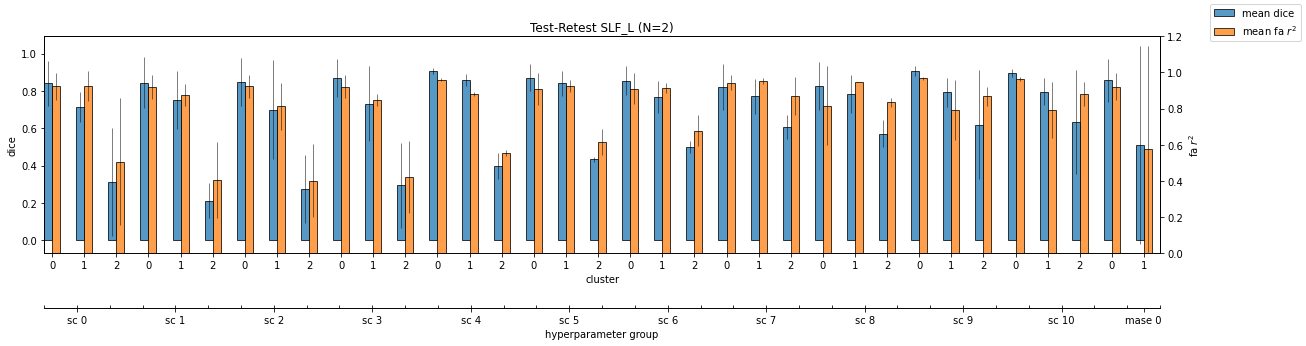

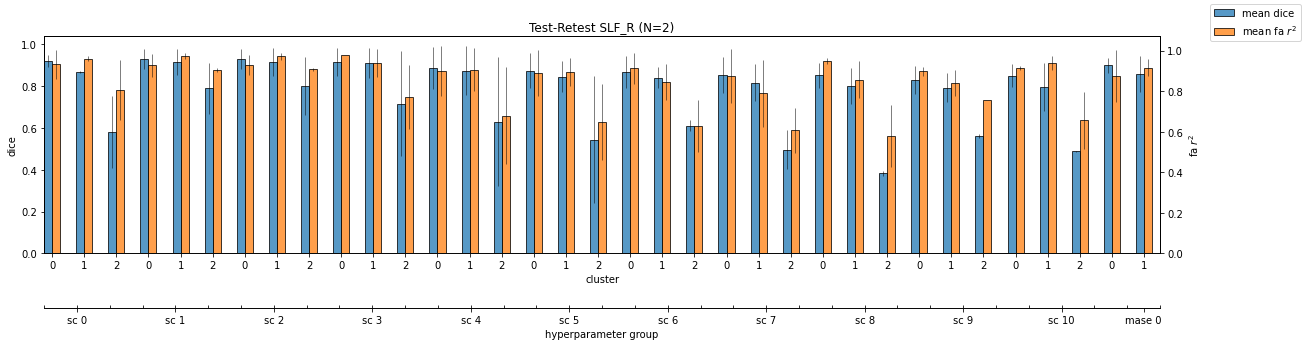

In [471]:
for bundle_name in bundle_names:
    frames = []
    for subject in subjects:
        df = summary_dfs[subject][bundle_name]
        df['subject'] = subject
        df.index.name='idx'
        frames.append(df)
    bundle_df = pd.concat(frames).groupby('idx').agg({'dice': ['mean', 'std'], 'fa_r2': ['mean', 'std']})
#     display(bundle_df)
    
    fig, ax = plt.subplots(figsize=(20,4))
    ax.set_ylabel('dice')

    ax2 = ax.twinx()
    ax2.set_ylabel('fa $r^2$')
    
#     bundle_df.dice.plot(kind='bar', y='mean', ax=ax, color='tab:blue', edgecolor='k', label='mean dice', alpha=0.75, yerr='std', error_kw=dict(ecolor='tab:blue',elinewidth=0.5), legend=False, width=0.25, position=1)
#     bundle_df.fa_r2.plot(kind='bar', y='mean', ax=ax2, color='tab:orange', edgecolor='k', label='mean fa $r^2$', alpha=0.75, yerr='std', error_kw=dict(ecolor='tab:orange',elinewidth=0.5),legend=False, width=0.25, position=0)
    bundle_df.dice.plot(kind='bar', y='mean', ax=ax, color='tab:blue', edgecolor='k', label='mean dice', alpha=0.75, yerr='std', error_kw=dict(elinewidth=0.5), legend=False, width=0.25, position=1)
    bundle_df.fa_r2.plot(kind='bar', y='mean', ax=ax2, color='tab:orange', edgecolor='k', label='mean fa $r^2$', alpha=0.75, yerr='std', error_kw=dict(elinewidth=0.5),legend=False, width=0.25, position=0)

    
    ax.set_xlabel('cluster')
    ax.set_xticklabels(getxticklabels(), rotation=0)

    ax1 = ax.twiny()
    ax1.xaxis.set_ticks_position('bottom')
    ax1.spines["bottom"].set_position(("axes", -0.25))
    ax1.set_xticks(range(len(df.index)))

    ax1.xaxis.set_major_locator(FixedLocator(getmodelxticklocations()))
    ax1.set_xticklabels(df['hyperparameter'].unique())
    ax1.set_xlabel('hyperparameter group')
    ax1.xaxis.set_label_position("bottom")
    
    ax3 = ax.twiny()
    ax3.xaxis.set_ticks_position('bottom')
    ax3.spines["bottom"].set_position(("axes", -0.25))
    ax3.set_xticks(range(len(df.index)))
#     ax3.xaxis.set_major_locator(FixedLocator([i for i in range(len(df.index)) if i not in [i for i in range(len(df.index))[1:len(df.index):3]]]))
    ax3.tick_params(labelbottom=False, direction='in') 

    fig.legend()
    plt.title(f'Test-Retest {bundle_name} (N={len(subjects)})')
    plt.show()

## subject reliablity

0.92909739177615

# Intrasubject

# Lateral